
# Toy example: Piecewise linear function

## Testing the Neural Incremental Posterior Estimation

#### Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [2]:
from utils import helpers
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

In [3]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C


import utils
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

## Piecewise_linear() and simulation wrappers for SBI

- piecewise_linear is taking 6 parameters (changing points and slopes) and outputs a three-part piecewise linear function

- piecewise_linear_seq is taking a list of either 2, 3 or 4 parameters and then outputs either a one-part. a two-part or a three-part piecewise linear function

In [4]:
start = get_time()



def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    

    return y


def piecewise_linear_seq(thetas):
    """
    I defined a seperate function for each sequential step such that we can vary different numbers of parameters
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    add_noise=0.2
    
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    
    if (len(thetas)==2):
        a1 = thetas[0]
        b = thetas[1]
        
        if not add_noise == None:
            a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)  
            
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
        
        return y[x<cp1]
    
     
    if (len(thetas)==3):     
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        
        if not add_noise == None:
            a1,b, a2 = np.array([a1,b, a2]) + scp.random.normal(scale=add_noise,size=3)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
        
        return y[x<cp2]
    
    
    if (len(thetas)==4):
        
        
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        a3 = thetas[3]
        
        if not add_noise == None:
            a1,b, a2, a3 = np.array([a1,b, a2, a3]) + scp.random.normal(scale=add_noise,size=4)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
        # third piece
        y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
        
        return y

    
  

### Define prior and summary stats dependent on prior

In [5]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)



## **Summary statistics**

definition of summary statistics for the piecewise linear function

In [6]:
"""
Summary stats
"""

def extract_sumstats(y,max_time=10):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    

    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        step_size = max_time/len(batch)
        
        
        x = torch.arange(0, max_time, step_size, dtype=torch.float64)
        
        
        
        
        batch[x>max_time] = np.nan
    
        s = np.zeros(10) * np.nan
        
        s[0] = np.float32(batch[0])    #offset
        s[1] = np.nanmin(batch[x<4])   # local min
        
        #print(type(s[0]), type(s[1]))
        s[2] = np.nanargmin(batch[x<4])   #value of min
    

        # second batch of sumstats for times > 4
        if max_time >= 4 :
            s[3] = np.nanmax(batch[(x>=4)&(x<8)])
            s[4] = np.nanmin(batch[(x>=4)&(x<8)])
            s[5] = np.nanargmin(batch[(x>=4)&(x<8)])

        # third batch of sumstats for times > 5
        if max_time >= 5:
            s[6] = np.nanmin(batch[x>=5])
            s[7] = np.nanargmin(batch[x>=5])
            
            s[8] = np.nanmax(batch[x>=5])
            s[9] = np.nanargmax(batch[x>=5])
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    
    

## Sequential Time Series SBI


We have the following parameters: a1,b,a2,a3, cp1, cp2

Let's assume this ground truth: true_params = $[5, 5, -3, 2, 1, 5]$

and the following uniform priors: 

prior_min = $[3, 3, -5, 0, -1, 3]  $

prior_max = $[7, 7, -1, 4, 3, 7]$


We start with inferring the first 2 parameters (a1, b), therefore call the function $piecewise_linear_first_batch()$
that only varies these 2 parameters within the prior range.

In [7]:
#parameter a1,b,a2,a3, cp1, cp2


prior_min = [3, 3, -5, 0]  

prior_max = [7, 7, -1, 4]

num_simulations=300

## First round

In [8]:
### first round:
from sbi import utils as utils

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])


#inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior1)
inf = SNPE_C(prior, density_estimator=density_estimator)


theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [9]:
x = extract_sumstats(x_without)

In [10]:
inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

 Neural network successfully converged after 66 epochs.

In [11]:
true_params = [5, 5]
obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])


In [12]:
num_samples = 1000

samples = posterior.sample((num_samples,), x=obs_real_stats)

proposal1 = posterior.set_default_x(obs_real_stats)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

So, the parameter range takes now only 15.775% of the uniform prior space!!

## Second round

In [13]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:3], high = prior_max[2:3])


prior_combined =Combined(proposal1, prior2, number_params_1=2)



density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined)

inf = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[5.1116, 4.6171]])
theta prior tensor([[-4.2875]])
theta shape torch.Size([1, 3])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[4.5872, 6.2925]])
theta prior tensor([[-4.0434]])
theta shape torch.Size([1, 3])
tensor([-4.9951])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[3.0173, 5.3652]])
theta prior tensor([[-3.9382]])
theta shape torch.Size([1, 3])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[4.8988, 4.7630]])
theta prior tensor([[-3.9014]])
theta shape torch.Size([1, 3])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[4.1708, 4.8346]])
theta prior tensor([[-1.6169]])
theta shape torch.Size([1, 3])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[4.6109, 4.7204],
        [5.4789, 4.9921]])
theta prior tensor([[-1.8943],
        [-2.2295]])
theta shape torch.Size([2, 3])


/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[5.1677, 5.5362]])
theta prior tensor([[-1.7291]])
theta shape torch.Size([1, 3])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[4.5615, 5.2694]])
theta prior tensor([[-2.6952]])
theta shape torch.Size([1, 3])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[4.9713, 5.0611]])
theta prior tensor([[-2.1317]])
theta shape torch.Size([1, 3])


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

theta posterior tensor([[5.1965, 5.1678],
        [4.7366, 5.6612],
        [5.2007, 4.4762],
        [6.2530, 5.1199],
        [6.7040, 4.7726],
        [4.8512, 5.2186],
        [5.5737, 4.9503],
        [4.9954, 5.1406],
        [6.1446, 5.1228],
        [4.8618, 5.2813],
        [4.5539, 5.0630],
        [4.8500, 5.0158],
        [5.2080, 5.1663],
        [5.3101, 5.0056],
        [3.6740, 5.0029],
        [4.5592, 5.5594],
        [4.8486, 4.9294],
        [4.7258, 5.3236],
        [5.1235, 4.8734],
        [5.0403, 5.3211],
        [4.7550, 5.1951],
        [5.2307, 5.7589],
        [4.8715, 4.4879],
        [4.9797, 4.8236],
        [5.1427, 4.0276],
        [4.9770, 5.1017],
        [5.0912, 5.1200],
        [4.8668, 5.2348],
        [5.2433, 5.1229],
        [5.6895, 5.3954],
        [4.9528, 5.1925],
        [5.4601, 4.7653],
        [4.7372, 5.7644],
        [4.8809, 4.9644],
        [5.5395, 5.1127],
        [4.7484, 5.3099],
        [4.8654, 5.0810],
        [4.6651, 5.034

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [14]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

 Neural network successfully converged after 45 epochs.

In [15]:
posterior2 = inf.build_posterior(density_estimator)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[4.7390, 5.2735],
        [5.0902, 4.7007],
        [4.6884, 5.1285],
        ...,
        [4.9799, 5.0237],
        [4.9050, 5.1839],
        [5.0995, 4.6810]])
theta prior tensor([[-3.2937],
        [-4.2391],
        [-1.1147],
        [-1.1801],
        [-1.4142],
        [-2.1671],
        [-2.9974],
        [-2.4452],
        [-4.4769],
        [-3.9713],
        [-1.8977],
        [-4.7116],
        [-1.5366],
        [-4.5572],
        [-3.9236],
        [-4.4870],
        [-2.7783],
        [-2.3695],
        [-2.8181],
        [-3.9293],
        [-2.5636],
        [-3.7466],
        [-1.9984],
        [-3.1408],
        [-3.5273],
        [-3.7172],
        [-2.5371],
        [-3.3671],
        [-2.4042],
        [-4.6890],
        [-3.2334],
        [-3.1495],
        [-2.6758],
        [-1.7050],
        [-1.1258],
        [-3.6030],
        [-4.7472],
        [-1.6557],
        [-3.6783],
        [-3.0129],
        [-4.2379],
        [-4.2059],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[5.1902, 5.2306],
        [5.0883, 5.1512],
        [5.0891, 5.0436],
        ...,
        [4.7912, 5.0565],
        [4.9203, 6.4469],
        [4.3134, 5.1724]])
theta prior tensor([[-2.8718],
        [-4.5807],
        [-2.5190],
        [-2.7070],
        [-1.0630],
        [-1.5013],
        [-3.2890],
        [-1.6303],
        [-1.5982],
        [-2.9948],
        [-4.4670],
        [-3.0661],
        [-4.8515],
        [-3.1960],
        [-2.9386],
        [-3.4106],
        [-1.0653],
        [-1.1141],
        [-3.2610],
        [-2.3343],
        [-1.2653],
        [-2.7898],
        [-4.9147],
        [-4.4005],
        [-2.3448],
        [-2.3064],
        [-3.9222],
        [-2.2537],
        [-4.0305],
        [-4.5277],
        [-4.3314],
        [-1.8197],
        [-4.3814],
        [-3.6465],
        [-1.3616],
        [-3.4265],
        [-3.5568],
        [-2.2390],
        [-4.3023],
        [-4.0796],
        [-3.6776],
        [-3.1958],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[5.4350, 4.1118],
        [5.1238, 5.0228],
        [6.0094, 4.9890],
        ...,
        [5.0060, 5.1814],
        [4.8313, 6.1325],
        [4.9951, 5.1957]])
theta prior tensor([[-3.2321],
        [-4.8818],
        [-2.6761],
        [-2.5665],
        [-1.5447],
        [-3.0251],
        [-1.4925],
        [-1.1952],
        [-3.9550],
        [-3.6565],
        [-3.9019],
        [-2.7708],
        [-3.1758],
        [-3.8036],
        [-3.1481],
        [-2.4813],
        [-2.1802],
        [-1.5229],
        [-4.0878],
        [-4.7795],
        [-2.7941],
        [-3.7451],
        [-4.8509],
        [-1.9076],
        [-4.2543],
        [-1.4398],
        [-3.5767],
        [-3.3972],
        [-1.2582],
        [-2.9355],
        [-2.9722],
        [-1.0861],
        [-2.0210],
        [-2.2414],
        [-2.3893],
        [-1.2956],
        [-2.4192],
        [-2.0770],
        [-4.7091],
        [-1.3474],
        [-3.0110],
        [-4.0710],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[5.0296, 5.2051],
        [5.3923, 5.0878],
        [4.4469, 4.8678],
        ...,
        [4.8678, 6.2323],
        [4.6357, 5.3108],
        [5.5214, 5.0610]])
theta prior tensor([[-4.9095],
        [-2.1296],
        [-3.4361],
        [-3.0214],
        [-1.6228],
        [-3.1221],
        [-2.9355],
        [-1.5036],
        [-2.7599],
        [-2.9549],
        [-2.4545],
        [-3.8767],
        [-4.0959],
        [-4.2521],
        [-2.9952],
        [-2.7829],
        [-1.8407],
        [-4.9285],
        [-3.8968],
        [-3.7719],
        [-2.6309],
        [-4.0676],
        [-4.9014],
        [-2.1001],
        [-1.0585],
        [-2.7549],
        [-3.6181],
        [-2.1803],
        [-1.0132],
        [-2.5678],
        [-2.4733],
        [-3.6488],
        [-4.6136],
        [-2.6947],
        [-3.2225],
        [-1.0350],
        [-1.9588],
        [-4.4372],
        [-1.0833],
        [-2.2336],
        [-3.2440],
        [-2.6755],
    

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[4.7736, 5.1009],
        [4.6660, 5.6489]])
theta prior tensor([[-3.1527],
        [-1.9754]])
theta shape torch.Size([2, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[4.8111, 5.8967],
        [5.1056, 5.0021],
        [4.7881, 6.2244],
        ...,
        [4.6782, 6.0604],
        [4.9478, 5.0170],
        [4.6591, 4.2032]])
theta prior tensor([[-1.4572],
        [-3.1114],
        [-3.8965],
        [-3.0217],
        [-3.6715],
        [-4.8534],
        [-2.4731],
        [-4.0810],
        [-4.5226],
        [-2.3703],
        [-3.6397],
        [-3.0159],
        [-3.6359],
        [-3.4066],
        [-2.6363],
        [-2.1733],
        [-1.9902],
        [-3.0813],
        [-1.0046],
        [-4.6365],
        [-2.7439],
        [-4.6958],
        [-3.5399],
        [-4.5421],
        [-4.8363],
        [-2.7176],
        [-2.5135],
        [-4.4531],
        [-1.6770],
        [-4.3199],
        [-4.2488],
        [-1.6844],
        [-3.7914],
        [-3.2414],
        [-4.1778],
        [-3.3265],
        [-2.6558],
        [-3.6125],
        [-3.0109],
        [-1.1950],
        [-4.0616],
        [-4.9440],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[4.4047, 5.6508],
        [4.7118, 5.8201],
        [4.9735, 4.8239],
        ...,
        [5.0939, 4.7809],
        [4.7917, 5.2204],
        [4.9875, 4.6045]])
theta prior tensor([[-3.7219],
        [-1.1353],
        [-1.0868],
        [-3.5542],
        [-1.6442],
        [-2.6721],
        [-4.7978],
        [-2.7448],
        [-4.6326],
        [-3.9659],
        [-1.8345],
        [-2.9788],
        [-1.8323],
        [-2.9374],
        [-3.6998],
        [-3.1709],
        [-2.5708],
        [-3.0757],
        [-2.3386],
        [-1.5296],
        [-1.0733],
        [-3.8929],
        [-1.4717],
        [-1.1591],
        [-1.5737],
        [-2.8187],
        [-2.0687],
        [-4.9594],
        [-3.0707],
        [-4.8230],
        [-1.8173],
        [-4.2000],
        [-1.4269],
        [-1.4872],
        [-2.1189],
        [-4.7838],
        [-3.2837],
        [-2.4175],
        [-2.7272],
        [-4.8868],
        [-3.7016],
        [-2.2523],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[4.7848, 5.2593],
        [5.0490, 4.9362],
        [4.8657, 4.3571],
        ...,
        [4.7430, 6.5464],
        [4.2087, 4.6862],
        [4.8412, 5.1668]])
theta prior tensor([[-3.6157],
        [-3.9252],
        [-2.1511],
        [-1.5792],
        [-1.1960],
        [-4.0059],
        [-1.2719],
        [-2.5345],
        [-2.8866],
        [-1.6422],
        [-2.3628],
        [-2.4377],
        [-4.2677],
        [-4.4898],
        [-1.2330],
        [-2.0613],
        [-3.8001],
        [-2.9116],
        [-4.8956],
        [-1.5505],
        [-4.1907],
        [-2.7990],
        [-1.7055],
        [-1.6388],
        [-3.0173],
        [-1.1590],
        [-4.3882],
        [-1.6447],
        [-1.6364],
        [-3.3542],
        [-3.9066],
        [-3.2551],
        [-4.1801],
        [-2.1276],
        [-1.1564],
        [-1.2647],
        [-3.1634],
        [-2.3474],
        [-4.6669],
        [-1.2241],
        [-2.6478],
        [-2.9473],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[4.9343, 5.1963],
        [4.6286, 5.1778],
        [5.0121, 4.1999],
        ...,
        [5.1494, 4.9135],
        [4.7909, 5.0133],
        [4.2788, 4.9294]])
theta prior tensor([[-2.2067],
        [-2.3950],
        [-4.3617],
        [-3.9902],
        [-4.9614],
        [-4.2463],
        [-2.4203],
        [-3.6975],
        [-1.4822],
        [-2.6671],
        [-4.0480],
        [-3.9815],
        [-4.5236],
        [-3.7245],
        [-2.9433],
        [-4.2588],
        [-2.6422],
        [-4.6757],
        [-1.0652],
        [-2.3433],
        [-2.3353],
        [-2.6557],
        [-3.4893],
        [-1.5385],
        [-3.8140],
        [-4.7896],
        [-2.3151],
        [-3.6586],
        [-4.3924],
        [-4.2864],
        [-4.5814],
        [-2.2795],
        [-3.2074],
        [-3.2778],
        [-1.1916],
        [-4.2228],
        [-1.5074],
        [-4.4314],
        [-2.3425],
        [-2.9362],
        [-2.0355],
        [-1.4760],
    

theta shape torch.Size([1000, 3])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[4.7924, 5.0196],
        [5.3582, 4.2238]])
theta prior tensor([[-2.1455],
        [-4.6540]])
theta shape torch.Size([2, 3])


In [16]:
true_params = [5,5,-3]


obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])


#print(proposal2.log_prob(theta))

samples = posterior2.sample((num_samples,), x=obs_real_stats)

proposal2 = posterior2.set_default_x(obs_real_stats)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

## Third and last round

In [25]:
#### third round



prior3 = utils.torchutils.BoxUniform(low=[prior_min[3]], high = [prior_max[3]])


prior_combined2 = Combined(proposal2, prior3, number_params_1=3)



density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined2)

inf = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 5.0677,  4.3603, -3.2880]])
theta prior tensor([[1.5065]])
theta shape torch.Size([1, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 4.5760,  4.8631, -3.0390]])
theta prior tensor([[2.5524]])
theta shape torch.Size([1, 4])
tensor([-4.6153])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 6.5044,  5.1021, -4.6823]])
theta prior tensor([[0.2355]])
theta shape torch.Size([1, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 5.3064,  5.0736, -3.6560]])
theta prior tensor([[1.7821]])
theta shape torch.Size([1, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 5.7239,  4.9755, -2.3130]])
theta prior tensor([[1.7427]])
theta shape torch.Size([1, 4])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[ 5.1242,  5.3105, -4.4993],
        [ 5.2134,  5.7063, -2.9301]])
theta prior tensor([[3.0888],
        [0.9478]])
theta shape torch.Size([2, 4])


/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 5.4139,  5.1911, -4.6685]])
theta prior tensor([[1.4783]])
theta shape torch.Size([1, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 5.2768,  5.0257, -3.3059]])
theta prior tensor([[3.4569]])
theta shape torch.Size([1, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 3.4505,  5.0116, -3.0341]])
theta prior tensor([[3.2292]])
theta shape torch.Size([1, 4])


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

theta posterior tensor([[ 4.9822,  5.1662, -3.4785],
        [ 5.1762,  4.3887, -3.2679],
        [ 5.3164,  5.4273, -1.2267],
        [ 5.3532,  5.4631, -3.3389],
        [ 5.5179,  4.3714, -3.0817],
        [ 4.4499,  5.2552, -3.3675],
        [ 5.0593,  4.0303, -3.2037],
        [ 5.2520,  5.1685, -3.2533],
        [ 5.1081,  5.1006, -3.3339],
        [ 5.2124,  5.0753, -4.0829],
        [ 5.3819,  5.1255, -4.3795],
        [ 5.0824,  4.8533, -3.1544],
        [ 5.0429,  5.0742, -3.4872],
        [ 5.4928,  4.5261, -2.4537],
        [ 5.6346,  5.0513, -3.8098],
        [ 5.5223,  5.1155, -3.3426],
        [ 4.9065,  5.1105, -3.2661],
        [ 5.3591,  5.5372, -3.2698],
        [ 4.9323,  5.0247, -2.4296],
        [ 5.0034,  5.6587, -3.5379],
        [ 5.2833,  5.2116, -3.3678],
        [ 5.5143,  4.9714, -3.2909],
        [ 4.8918,  4.8155, -3.3024],
        [ 5.2682,  4.7961, -2.2616],
        [ 5.0532,  5.0802, -3.6242],
        [ 3.6117,  5.0942, -4.0224],
        [ 5.0772,  5.0

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [26]:
x = extract_sumstats(x_without)


print(x.shape)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior3 = inf.build_posterior(density_estimator)

torch.Size([300, 10])
 Neural network successfully converged after 74 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 5.1330,  5.1029, -1.4944],
        [ 5.5366,  5.0918, -4.4832],
        [ 5.2381,  4.8217, -3.9868],
        ...,
        [ 5.4774,  5.3915, -4.7083],
        [ 5.5311,  5.0252, -4.4142],
        [ 5.3657,  5.2625, -3.5352]])
theta prior tensor([[3.7684],
        [2.1975],
        [0.5661],
        [0.5854],
        [1.4487],
        [3.6717],
        [0.0775],
        [1.0582],
        [2.9428],
        [2.6146],
        [0.3916],
        [0.7998],
        [2.2349],
        [2.9275],
        [3.2020],
        [2.4784],
        [3.5370],
        [2.2995],
        [2.2391],
        [1.5799],
        [1.4289],
        [1.1628],
        [0.1711],
        [0.1596],
        [0.7759],
        [0.6579],
        [2.1744],
        [0.1773],
        [1.1799],
        [3.9491],
        [3.0129],
        [3.1656],
        [2.9593],
        [3.5170],
        [2.3416],
        [3.3154],
        [1.5383],
        [1.1084],
        [0.7491],
        [0.1225],
        [1.3426]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 5.3218,  5.0237, -4.0986],
        [ 5.2407,  4.8438, -3.3519],
        [ 5.2168,  5.5838, -4.4017],
        ...,
        [ 5.2030,  5.1928, -4.0404],
        [ 5.3988,  5.4103, -3.7627],
        [ 5.2051,  5.9735, -3.5498]])
theta prior tensor([[2.0187],
        [0.2064],
        [2.3452],
        [0.6127],
        [2.6747],
        [3.7724],
        [3.0951],
        [2.8463],
        [3.5071],
        [3.7238],
        [3.5039],
        [1.7765],
        [3.1215],
        [0.4026],
        [1.4219],
        [2.3497],
        [3.1129],
        [0.0947],
        [2.5971],
        [0.7219],
        [3.4677],
        [1.2951],
        [2.5697],
        [0.0191],
        [2.4828],
        [2.9113],
        [2.7220],
        [1.6794],
        [2.4967],
        [0.8432],
        [0.9925],
        [2.2487],
        [3.3583],
        [3.2419],
        [3.8305],
        [0.3519],
        [2.5989],
        [0.6231],
        [1.1816],
        [3.2230],
        [0.5939]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 5.1676,  5.1226, -4.9188],
        [ 5.2292,  5.1066, -2.8937],
        [ 5.0039,  5.0280, -2.9929],
        ...,
        [ 4.8534,  5.1445, -4.0604],
        [ 5.1684,  4.8651, -3.5768],
        [ 5.1477,  4.6682, -2.8775]])
theta prior tensor([[1.3466e+00],
        [3.6175e+00],
        [2.1023e+00],
        [2.3987e+00],
        [2.7565e+00],
        [4.4811e-02],
        [2.8170e-01],
        [3.2775e-01],
        [1.6064e+00],
        [2.3518e+00],
        [3.8832e+00],
        [3.3034e+00],
        [2.1155e+00],
        [3.4826e+00],
        [2.9650e+00],
        [2.4639e+00],
        [3.7401e+00],
        [2.9240e+00],
        [1.5043e-01],
        [1.5112e+00],
        [3.1975e+00],
        [1.6755e+00],
        [1.5903e+00],
        [2.7601e+00],
        [2.0974e+00],
        [3.3872e+00],
        [2.8184e+00],
        [6.4008e-01],
        [3.9159e-01],
        [3.2242e+00],
        [3.5415e+00],
        [1.7832e+00],
        [8.1990e-01],
        [2

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 5.2508,  5.0841, -3.4825],
        [ 5.5067,  4.7500, -4.1403],
        [ 5.3773,  4.2938, -4.2037],
        ...,
        [ 5.1358,  4.4881, -3.2716],
        [ 5.3278,  4.9321, -1.9705],
        [ 5.2982,  5.1271, -3.1569]])
theta prior tensor([[2.5829e+00],
        [8.9101e-02],
        [8.2211e-01],
        [5.1582e-01],
        [3.2699e+00],
        [2.2149e+00],
        [1.0591e+00],
        [2.5245e+00],
        [1.7578e+00],
        [2.6295e+00],
        [2.7230e+00],
        [2.5730e+00],
        [3.2066e-01],
        [3.0320e+00],
        [3.7781e+00],
        [1.1870e+00],
        [1.1856e+00],
        [2.7207e+00],
        [8.7378e-01],
        [1.2587e-01],
        [1.9406e+00],
        [3.9568e+00],
        [3.6754e+00],
        [1.4544e+00],
        [4.0546e-01],
        [2.4844e+00],
        [1.0572e+00],
        [1.6430e+00],
        [3.0579e+00],
        [7.6017e-01],
        [2.6201e+00],
        [2.6170e-02],
        [3.4189e+00],
        [2

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[ 5.0985,  4.5149, -3.5703],
        [ 5.1920,  5.4287, -4.1324]])
theta prior tensor([[3.0199],
        [1.9260]])
theta shape torch.Size([2, 4])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 4.9873,  5.0374, -3.8813],
        [ 5.1430,  4.9944, -3.1632],
        [ 5.3921,  4.7323, -2.9749],
        ...,
        [ 3.9343,  5.2621, -3.0626],
        [ 5.1343,  5.0017, -1.4130],
        [ 5.4426,  5.8708, -2.9159]])
theta prior tensor([[2.8136e+00],
        [2.3568e+00],
        [1.5198e+00],
        [8.1386e-01],
        [3.8212e+00],
        [4.8460e-01],
        [1.5545e+00],
        [5.6355e-01],
        [2.9823e+00],
        [1.9416e+00],
        [1.5957e+00],
        [3.8032e+00],
        [3.9241e+00],
        [5.3000e-01],
        [1.1697e+00],
        [3.8268e+00],
        [2.1420e+00],
        [2.2966e+00],
        [3.8705e+00],
        [3.9050e+00],
        [3.8215e+00],
        [1.4014e+00],
        [9.7988e-01],
        [3.0119e+00],
        [1.5197e+00],
        [3.6543e-01],
        [3.3734e+00],
        [3.2715e+00],
        [3.1324e+00],
        [3.4017e+00],
        [5.3417e-02],
        [2.7273e+00],
        [1.7491e+00],
        [3

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 5.1268,  5.5619, -4.2210],
        [ 5.2596,  5.0962, -4.4992],
        [ 5.3457,  5.2230, -3.6914],
        ...,
        [ 5.6334,  4.9970, -3.4358],
        [ 5.4334,  4.9148, -3.5676],
        [ 5.1389,  5.1054, -3.0727]])
theta prior tensor([[3.1255e+00],
        [1.2855e+00],
        [2.7557e+00],
        [2.6392e+00],
        [2.8137e+00],
        [1.2938e+00],
        [3.0786e+00],
        [3.2910e+00],
        [2.7588e+00],
        [1.3385e+00],
        [1.3731e+00],
        [3.6257e+00],
        [2.2480e+00],
        [1.6245e+00],
        [1.6337e+00],
        [1.8954e+00],
        [1.7451e+00],
        [2.8720e+00],
        [3.2364e+00],
        [1.7925e+00],
        [7.6227e-02],
        [9.3341e-01],
        [1.6254e+00],
        [3.9130e+00],
        [2.6900e+00],
        [2.3681e+00],
        [3.4540e+00],
        [8.4491e-01],
        [8.5927e-01],
        [4.5440e-01],
        [9.3415e-01],
        [9.0679e-01],
        [2.2373e+00],
        [1

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 6.0060,  4.4940, -3.1055],
        [ 5.2776,  5.0666, -2.1896],
        [ 5.3490,  5.3671, -4.1306],
        ...,
        [ 5.3166,  5.5144, -3.2607],
        [ 5.0655,  5.1015, -4.0308],
        [ 5.7327,  5.0558, -3.4127]])
theta prior tensor([[0.6328],
        [1.3845],
        [0.1248],
        [0.6529],
        [3.1462],
        [2.6103],
        [1.1373],
        [2.3816],
        [1.2102],
        [1.2016],
        [0.4044],
        [3.7200],
        [0.9936],
        [1.5372],
        [2.7442],
        [0.5954],
        [0.6526],
        [3.5489],
        [0.2684],
        [0.7769],
        [0.7702],
        [3.7093],
        [3.1168],
        [1.4426],
        [3.7858],
        [3.8402],
        [3.1400],
        [3.2095],
        [2.2924],
        [0.0930],
        [0.8797],
        [2.2352],
        [1.2810],
        [0.9252],
        [2.2106],
        [0.6012],
        [3.9071],
        [1.8442],
        [3.1483],
        [0.1811],
        [2.3548]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 5.7146,  4.3646, -3.5086],
        [ 5.3783,  5.0523, -3.8289],
        [ 5.1292,  5.0444, -3.0519],
        ...,
        [ 5.1736,  4.3553, -3.0402],
        [ 5.3287,  4.7758, -3.4556],
        [ 5.0137,  5.1800, -3.1809]])
theta prior tensor([[2.9171],
        [0.1791],
        [2.3366],
        [2.7671],
        [0.5536],
        [0.2925],
        [3.5058],
        [1.9295],
        [2.5547],
        [3.6260],
        [3.0862],
        [1.0487],
        [2.9694],
        [2.0210],
        [1.6978],
        [2.7085],
        [2.4402],
        [3.8833],
        [1.7870],
        [0.7457],
        [2.6620],
        [1.7444],
        [3.8626],
        [1.2109],
        [0.7517],
        [3.0468],
        [0.6785],
        [1.1661],
        [0.6230],
        [3.2216],
        [2.6664],
        [0.5998],
        [2.5455],
        [2.0725],
        [1.7725],
        [1.1423],
        [2.5647],
        [0.0532],
        [1.4057],
        [3.5296],
        [1.0097]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[ 5.3922,  5.0207, -3.4719],
        [ 5.4556,  5.0362, -3.9942]])
theta prior tensor([[1.7664],
        [0.9199]])
theta shape torch.Size([2, 4])


In [28]:
true_params = [5, 5, -3, 2]

obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])[0]

print(obs_real_stats)


samples = posterior3.sample((1000,), x=obs_real_stats)

tensor([  4.7917,   4.7917,   0.0000,  17.3886,  11.2850, 199.0000,  11.2850,
         99.0000,  18.2616, 499.0000])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)

tensor([  5.0099,   5.0099,   0.0000,  17.3978,  11.6031, 199.0000,  11.6031,
         99.0000,  19.1057, 499.0000])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
end = get_time()


print('start:', start, '\nend:', end)

start: 02-10-2022_16:27:00 
end: 02-10-2022_17:23:35


In [48]:
from joblib import Parallel, delayed

num_workers = 4
x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples)


s_x_prior = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples_prior)

In [49]:
s_x_stat = extract_sumstats(s_x)

s_x_prior_stat = extract_sumstats(s_x_prior)



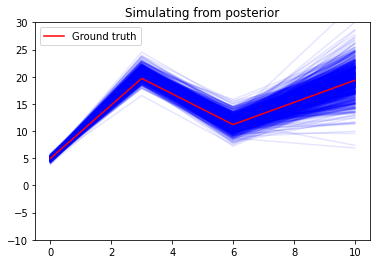

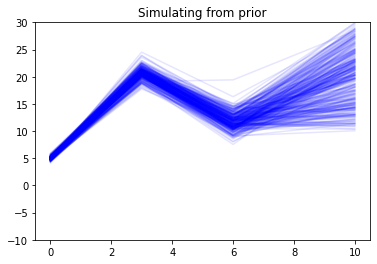

In [50]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    im = plt.plot(x_lin, s, alpha=0.1, color='blue')
    plt.ylim(-10,30)
plt.plot(x_lin, obs_real, label='Ground truth', color='red')
plt.legend()
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in x_without:
    plt.plot(x_lin, x_w, alpha=0.1, color='blue')

    plt.ylim(-10,30)


  

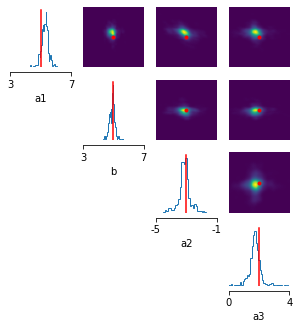

In [39]:
limits = [list(tup) for tup in zip(prior_min, prior_max)]

true_params = torch.tensor([[5, 5, -3, 2, 1, 5]])

parameter_names = ['a1', 'b', 'a2', 'a3']

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(5, 5),
    upper = "kde",
    points=true_params[0:2],
    points_offdiag={"markersize": 6},
    points_colors="r",
    #tick_labels=parameter_names
    labels=parameter_names,
)

### Validating summary statistics with histogram plots

We should see that posterior is restricting the area of values

10
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])


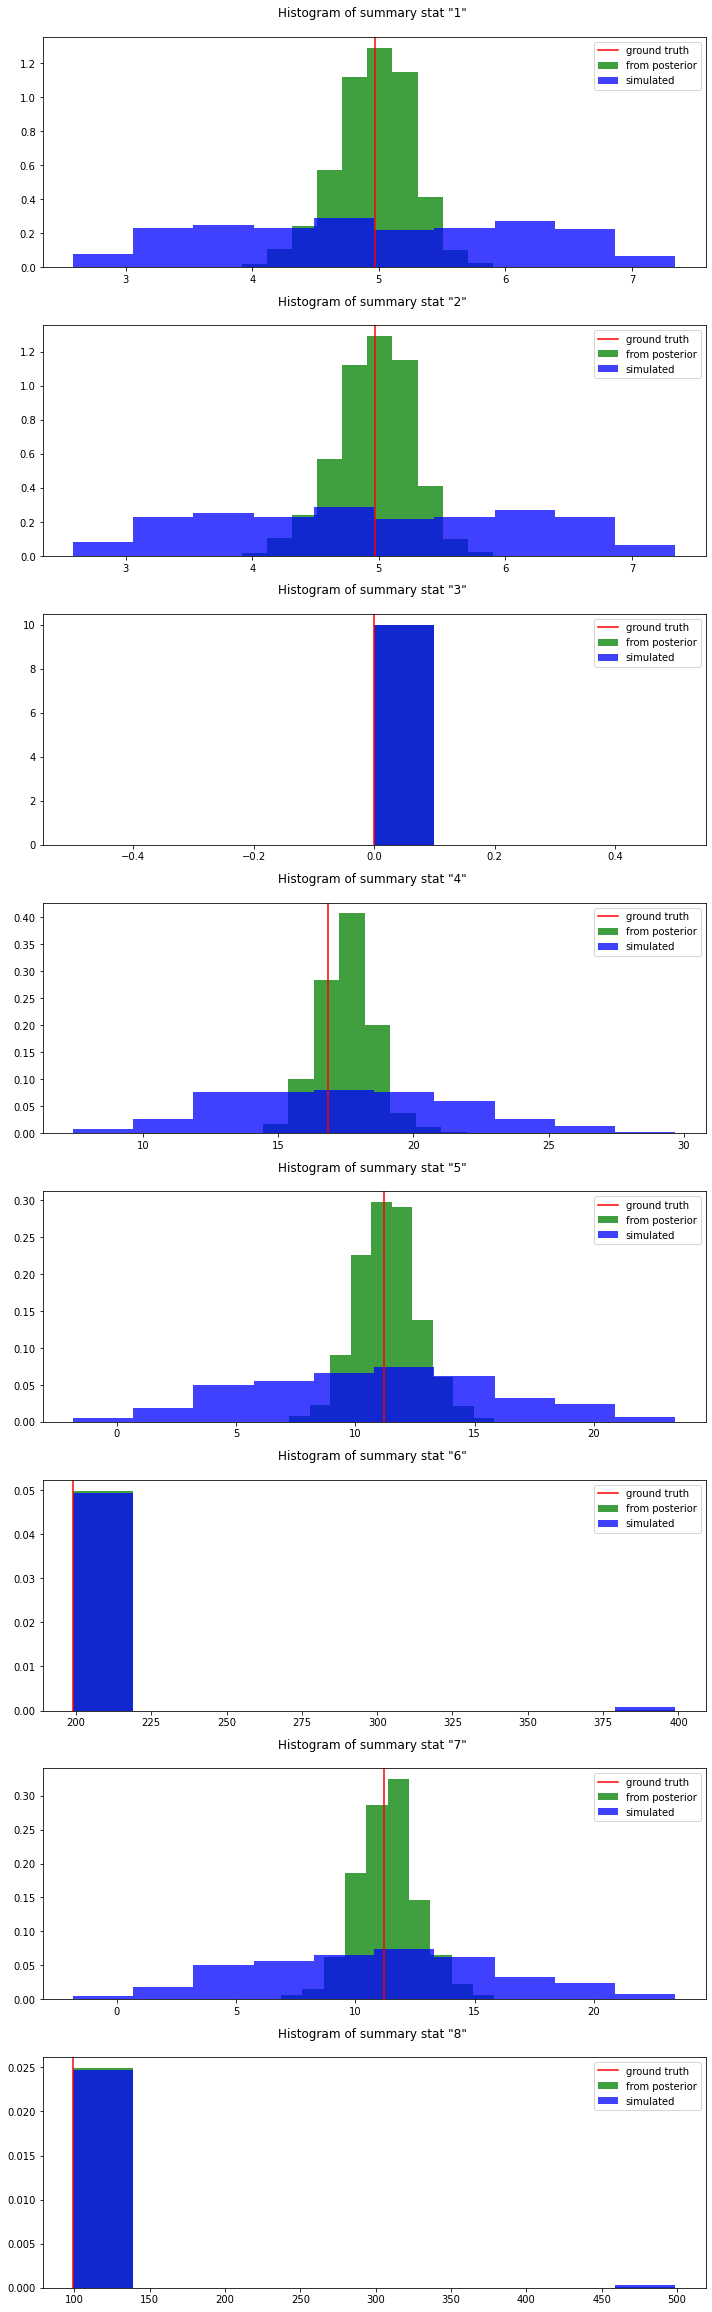

In [52]:
import matplotlib.gridspec as gridspec



fig = plt.figure(figsize=(10,40), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)
print(len(s_x_stat[0]))

sum_stats_names = torch.arange(1, len(s_x_stat[0]), 1)

print(sum_stats_names)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)-1):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)-1):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=True, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=True, facecolor='b', alpha=0.75, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stats[i], color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')